# Stellar Irradiation

The default temperature profile of DustPy is that of a passively irradiated disk

$\Large T\left(r\right) = \sqrt[4]{\frac{1}{2}\frac{\varphi L_*}{4\pi r^2 \sigma_\mathrm{SB}}}$

with a constant irradiation angle of $\varphi = 0.05$. The irradiation angle, however, is typically not constant, but depends on the height profile of the disk and therefore on the temperature itself ([Chiang & Goldreich, 1997](https://ui.adsabs.harvard.edu/abs/1997ApJ...490..368C/abstract)):

$\Large \varphi \left( r \right) = \frac{0.04 R_*}{r} + r\frac{\mathrm{d}}{\mathrm{d}r} \left( \frac{H_\mathrm{s}}{r} \right)$.

$H_\mathrm{s}$ is the surface height, i.e., the height above the midplane at which the optical depth $\tau_r$ of the disk to the stellar radiation is greater than $1$.

[Dullemond et al. (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...560..957D/abstract) showed that this is identical to solving the equation

$\Large 1 - \mathrm{erf} \left( \frac{H_\mathrm{s}}{\sqrt{2}H_\mathrm{P}} \right) = \frac{2\varphi}{\tau}$

with $\tau_r = \tau/\varphi$. Since $H_\mathrm{s}$ depends on the temperature $T$ via the flaring angle $\varphi$ and vice-versa, this has to be solved iteratively.

## The Project

The goal of this project is to implement a self-consistent temperature profile, i.e., a profile that does not assume a constant flaring angle $\varphi$.

In a first step you can use DustPyLib and run a thermal RADMC-3D model of the default DustPy setup to compare the midplane temperature DustPy assumes with the result from RADMC-3D. A detailed manual how to achieve this can be found in the [DustPyLib documentation](https://dustpylib.readthedocs.io/en/latest/radmc3d.html#Thermal-Monte-Carlo-run).

In the next step you can add fields for the surface height and the flaring angle into the DustPy simulation object, write functions to compute them and add them to their updaters.

Finally, modify the temperature function to compute the flaring angle self-consistently.

**Warning:** This iterative problem can be unstable.

To solve the equation for $H_\mathrm{s}$ you can use `scipy.optimize.brentq`. The error function can be found in `scipy.special.erf`.

## Creating simulation object

In [1]:
from dustpy import constants as c
from dustpy import Simulation
import numpy as np

In [2]:
sim = Simulation()
sim.ini.star.M = 0.1 * c.M_sun
sim.ini.gas.Mdisk = 0.05 * sim.ini.star.M
sim.ini.dust.allowDriftingParticles = True
sim.initialize()

## Creating/loading opacity file

To compute the optical depth we need some opacity model. We are using `dsharp_opac` to compute the DSHARP opacities ([Birnstiel et al., 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..45B/abstract)). This has to be only done once. The result is stored in a file that can be used later.

In [3]:
opacfile = "dsharp.npz"

In [4]:
from pathlib import Path

In [5]:
opacdir = Path("opacities")
opacpath = opacdir.joinpath(opacfile)

In [6]:
# Compute opacities only if opacity file does not exist
if not opacpath.is_file():
    # Create opacity directory if it does not exist
    opacdir.mkdir(exist_ok=True, parents=True)
    # Size and wavelength grid
    a = np.geomspace(1.e-6, 1.e2, 161)
    lam = np.geomspace(1.e-5, 1.e1, 121)
    import dsharp_opac as do
    mix, rhos = do.get_dsharp_mix()
    opac = do.get_opacities(a, lam, rhos, mix, extrapol=True, extrapolate_large_grains=True)
    # Saving to file
    np.savez(
        opacfile,
        a = a,
        lam = lam,
        k_abs = opac["k_abs"],
        k_sca = opac["k_sca"],
        g = opac["g"]
    )

## Computing Planck mean opacity

We are using the DSHARP opacities to compute an average opacity over the stellar spectrum. This is called the Planck mean opacity and is defined as

$\Large \kappa_\mathrm{P} \left( a,  T_* \right) = \frac{\int\limits_0^\infty \kappa_\nu \left(a\right) B_\nu\left(T_*\right)\mathrm{d}\nu}{\int\limits_0^\infty B_\nu\left(T_*\right)\mathrm{d}\nu}$

for a given particle size $a$ at a given stellar temperature $T_*$.

The optical thickness is then given as the sum over all particle bins

$\Large \tau = \sum\limits_{i=1}^{N_m} \Sigma_{\mathrm{d}, i} \cdot \kappa_\mathrm{P} \left(a_i, T_*\right)$.

We therefore need to write a function that computes the Planck function $B_\nu$. The Planck mean opacity could be pre-computed and stored in a lookup table. Here we are using `scipy.interpolate.RegularGridInterpolator`, which is doing that for us and interpolating for us later at the desired size and temperature points.

In [7]:
from astropy import constants as ac
from scipy.interpolate import RegularGridInterpolator
import warnings

The exponential function can raise some warnings if the arguments are too large. We are turning them off.

In [8]:
def B_nu(nu, T):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        exp = np.exp(nu/T * ac.h.cgs.value / ac.k_B.cgs.value)
    return 2 * ac.h.cgs.value * nu**3 / ac.c.cgs.value / (exp-1.)

This function takes the opacity file we created earlier and uses `RegularGridInterpolator` to compute the Planck mean opacity. The result is a function $\kappa_\mathrm{P} \left( a,  T_* \right)$ that can be used to easily (and quickly) get the Planck mean opacity.

In [9]:
def compute_planck_mean(npzfile):
    opac = np.load(npzfile)
    # We are using the size and frequency/wavelength grid from the opacity file
    a = opac["a"]
    lam = opac["lam"]
    nu = ac.c.cgs.value/lam
    # The Planck mean opacity is computed using the absorption opacity
    k_abs = opac["k_abs"]
    # Temperature grid
    T = np.geomspace(0.1, 1.e5, 1000)
    # Planck mean opacity
    up = np.trapz(k_abs[..., None] * B_nu(nu[:, None], T[None, :])[None, ...], x=nu, axis=1)
    down = np.trapz(B_nu(nu[:, None], T[None, :]), x=nu, axis=0)
    k_p = up/down[None, ...]
    k_planck = RegularGridInterpolator((a, T), k_p)
    return k_planck

We can now check if the Interpolator works as intended, by plotting the opacity at given temperatures.

In [10]:
k_planck = compute_planck_mean(opacpath)

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

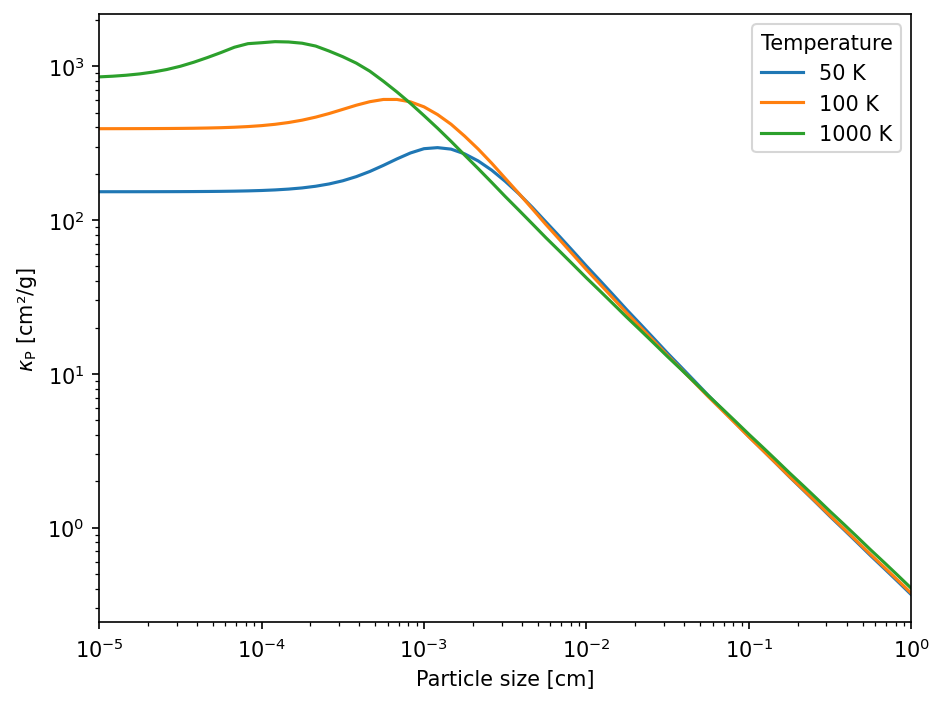

In [12]:
fig, ax = plt.subplots()
a = np.geomspace(1.e-5, 1., 61)
T = [50., 100., 1000.]
for temp in T:
    ax.loglog(a, k_planck((a, temp)), label="{:.0f} K".format(temp))
ax.set_xlim(a.min(), a.max())
ax.set_xlabel("Particle size [cm]")
ax.set_ylabel("$\kappa_\mathrm{P}$ [cm²/g]")
ax.legend(title="Temperature")
fig.tight_layout()

## Adding opacity related fields

We are storing the opacity related fields in a separate group within our simulation object.

In [13]:
sim.addgroup("opacities", description="Opacity related parameters")

The interpolator for the Planck mean opacity is stored in a hidden attribute and can be accessed by other functions.

In [14]:
sim.opacities._kp = k_planck

In the next step we add a field for the Planck mean opacity and write a function that computes the opacity at every radial grid cell for every particle size. This function is then added to the updater of the field. Technically, neither the particle size grid, nor the stellar temperature changes in the default simulation setup. The field is therefore constant throughout the simulation.

In [15]:
def kappa_planck(sim):
    return sim.opacities._kp((sim.dust.a, sim.star.T))

In [16]:
sim.opacities.addfield("k_planck", np.zeros_like(sim.dust.Sigma), description="Planck mean opacity [cm²/g]")
sim.opacities.k_planck.updater = kappa_planck
sim.opacities.k_planck.update()

Next we are adding a field for the optical depth.

In [17]:
def tau(sim):
    return (sim.opacities.k_planck*sim.dust.Sigma).sum(-1)

In [18]:
sim.opacities.addfield("tau", np.zeros_like(sim.gas.Sigma), description="Optical depth")
sim.opacities.tau.updater = tau
sim.opacities.tau.update()

We can inspect the optical depth to see that the disk is optically thick in the inner and optically thin in the outer parts.

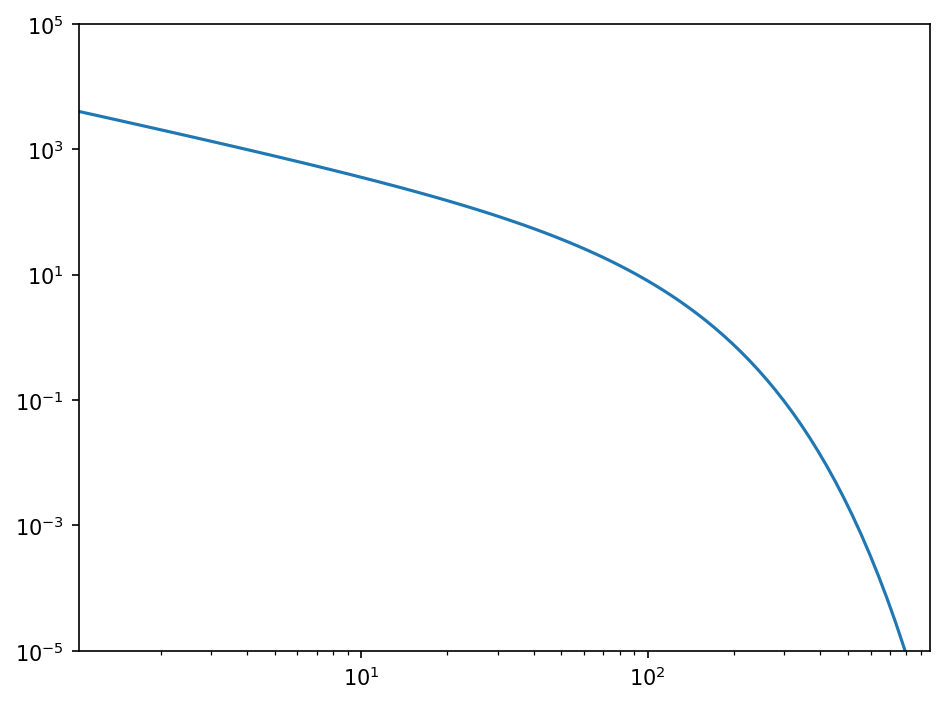

In [19]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.opacities.tau)
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
ax.set_ylim(1.e-5, 1.e5)
fig.tight_layout()

And finally we add an updater for the entire opacity group.

In [20]:
sim.opacities.updater = ["k_planck", "tau"]

## Adding fields for flaring index, flaring angle, and surface height

Now comes the fun part. We need fields for the flaring angle, the flaring index, and the disk surface. The flaring angle is easy and computed from the flaring index.

In [21]:
sim.gas.addfield("flindex", np.zeros_like(sim.gas.Sigma), description="Flaring index")
sim.gas.addfield("flangle", 0.05*np.ones_like(sim.gas.Sigma), description="Flaring angle")
sim.gas.addfield("Hs", np.zeros_like(sim.gas.Sigma), description="Surface height [cm]")

In [22]:
def flangle(sim):
    return sim.gas.flindex*sim.gas.Hs/sim.grid.r + 0.4*sim.star.R/sim.grid.r

In [23]:
sim.gas.flangle.updater = flangle

The flaring index is more complicated. Here we are only computing the flaring index at every third grid cell and copy values in between. This is to make the overall profile more smooth. You can try other values on your own by changing the `stride` parameter.

In [24]:
def flindex(sim):
    Nr = int(sim.grid.Nr)
    flidx = np.zeros_like(sim.gas.Sigma)
    flmin = 1.e-2
    stride = 3
    for ir in range(2, Nr, stride):
        hr2 = sim.gas.Hs[ir-2] / sim.grid.r[ir-2]
        hr1 = sim.gas.Hs[ir-1] / sim.grid.r[ir-1]
        if hr1 > 0.0 and hr2 > 0.0:
            flidx[ir] = (sim.grid.r[ir-2] + sim.grid.r[ir-1]) * (hr2-hr1) / ((sim.grid.r[ir-2] - sim.grid.r[ir-1]) * (hr2 + hr1))
        else:
            flidx[ir] = flidx[ir - 1]
        for i in range(1, stride):
            j = ir+i
            if j > Nr-1:
                continue
            flidx[j] = flidx[ir]
    flidx[:2] = flidx[2]
    flidx = np.maximum(flmin, flidx)
    return flidx

In [25]:
sim.gas.flindex.updater = flindex

And finally we need a function to compute the disk surface height from the flaring angle, the optical depth and the pressure scale height. You can use `scipy.optimize.brentq` to solve for $H_\mathrm{s}$.

In [26]:
from scipy.optimize import brentq

In [27]:
help(brentq)

Help on function brentq in module scipy.optimize._zeros_py:

brentq(f, a, b, args=(), xtol=2e-12, rtol=8.881784197001252e-16, maxiter=100, full_output=False, disp=True)
    Find a root of a function in a bracketing interval using Brent's method.
    
    Uses the classic Brent's method to find a zero of the function `f` on
    the sign changing interval [a , b]. Generally considered the best of the
    rootfinding routines here. It is a safe version of the secant method that
    uses inverse quadratic extrapolation. Brent's method combines root
    bracketing, interval bisection, and inverse quadratic interpolation. It is
    sometimes known as the van Wijngaarden-Dekker-Brent method. Brent (1973)
    claims convergence is guaranteed for functions computable within [a,b].
    
    [Brent1973]_ provides the classic description of the algorithm. Another
    description can be found in a recent edition of Numerical Recipes, including
    [PressEtal1992]_. A third description is at
    htt

In [28]:
def Hs(sim):
    # Write a function that computes the surface height
    pass

In [29]:
sim.gas.Hs.updater = Hs

## Compute the temperature profile

Now we have to compute the temperature profile. This is a bit tricky. We have to iterate serveral time and update the temperature. We cannot call `sim.gas.T.update()` in the updater itself, because that would cause infinite recursions. We therefore manually set the temperature in the loop within the updater. Add the update of the other required fields here.

In [32]:
def T(sim):
    # Compute the temperature iteratively while updating the flaring angle from the new temperature.
    # Do not forget to update other quantities that depend on it.
    for i in range(100):
        # Add the updates of the other fields here.
        sim.gas.T[:] = (0.125*sim.gas.flangle*sim.star.L / (np.pi*sim.grid.r**2*c.sigma_sb))**0.25
    return T

In [31]:
sim.gas.T.updater = T